dfgdsfgdfs

In [1]:
from google.colab import drive
import os
import pickle
import tensorflow_gcs_config
import shutil
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import nibabel as nib
import tensorflow_hub as hub
# drive.mount('/content/MyDrive/')
# os.chdir('/content/MyDrive/MyDrive/IDS705_Final') #change to file path on your disk

In [2]:
from google.colab import auth
auth.authenticate_user()


In [3]:
# TODO: set these to the names of your project and bucket
!gcloud config set project ids705
os.environ['TFHUB_CACHE_DIR'] = os.path.join('gs://ids705_1/_tfhub_cache')

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

Are you sure you wish to set property [core/project] to ids705?

Do you want to continue (Y/n)?  Y

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud survey



In [10]:
tensorflow_gcs_config.configure_gcs_from_colab_auth()

FileNotFoundError: ignored

In [6]:
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU')]

In [7]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
tpu_strategy = tf.distribute.experimental.TPUStrategy(resolver)

Tensorflow version 2.8.0
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.45.229.74:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.45.229.74:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [9]:
os.listdir('sample_data')

['README.md',
 'anscombe.json',
 'mnist_test.csv',
 'mnist_train_small.csv',
 'california_housing_test.csv',
 'california_housing_train.csv']

In [4]:
#Create Train / Val / Test Split
subfolders = os.listdir("Data/Train")
np.random.seed(101)
split = np.random.choice(["Train","Val","Test"], len(subfolders), p=[0.6, 0.2, 0.2])
train_ids = [subfolders[i] for i,v in enumerate(split) if v=="Train"]
val_ids = [subfolders[i] for i,v in enumerate(split) if v=="Val"]
test_ids = [subfolders[i] for i,v in enumerate(split) if v=="Test"]

In [5]:
#Helper Functions
def parse_tfrecord(example):
  """
  This function helps in parsing tfrecord files when creating a TF Dataset object
  """
  feature = {'image': tf.io.FixedLenFeature([240, 240, 155, 4], tf.float32),
             'label': tf.io.FixedLenFeature([240, 240, 155], tf.int64)}
  parsed_example = tf.io.parse_single_example(example, feature)
  return parsed_example

def get_image_and_label(features):
  """
  Extract Image and Label Object from tfrecord files
  """
  image, label = features['image'], features['label']
  return image, label

def get_dataset(tfrecord_names):
  """
  Create TF dataset files that can be fed into model functions
  """
  dataset = (tf.data.TFRecordDataset(tfrecord_names)
             .map(parse_tfrecord)
             .map(get_image_and_label))

  return dataset

In [6]:
#Create dataset objects
train_dataset = get_dataset([f'/content/MyDrive/MyDrive/IDS705_Final/Data/train_tf/{sf}.tfrecord' for sf in train_ids])
test_dataset = get_dataset([f'/content/MyDrive/MyDrive/IDS705_Final/Data/train_tf/{sf}.tfrecord' for sf in test_ids])
val_dataset = get_dataset([f'/content/MyDrive/MyDrive/IDS705_Final/Data/train_tf/{sf}.tfrecord' for sf in val_ids])
mini_dataset = get_dataset([f'/content/MyDrive/MyDrive/IDS705_Final/Data/train_tf/{sf}.tfrecord' for sf in subfolders[100:228]])
minival_dataset = get_dataset([f'/content/MyDrive/MyDrive/IDS705_Final/Data/train_tf/{sf}.tfrecord' for sf in subfolders[500:508]])

Model Architecture

In [20]:
def gen_model(lr=1e-3):
    input_layer = tf.keras.layers.Input(shape=(240,240,155,4))

    x4 = tf.keras.layers.BatchNormalization()(input_layer)
    x4 = tf.keras.layers.Conv3D( 4, 3, strides=(1,1,1), activation='relu', padding='same')(x4)
    x4 = tf.keras.layers.BatchNormalization()(x4)
    x4 = tf.keras.layers.Conv3D( 4, 3, strides=(1,1,1), activation='relu', padding='same')(x4)
    x4 = tf.keras.layers.BatchNormalization()(x4)

    x8 = tf.keras.layers.Conv3D( 8, 3, strides=(2,2,2), activation='relu', padding='same')(x4)
    x8 = tf.keras.layers.BatchNormalization()(x8)
    x8 = tf.keras.layers.Conv3D( 8, 3, strides=(1,1,1), activation='relu', padding='same')(x8)
    x8 = tf.keras.layers.BatchNormalization()(x8)

    x16 = tf.keras.layers.Conv3D(16, 3, strides=(2,2,2), activation='relu', padding='same')(x8)
    x16 = tf.keras.layers.BatchNormalization()(x16)
    x16 = tf.keras.layers.Conv3D(16, 3, strides=(1,1,1), activation='relu', padding='same')(x16)
    x16 = tf.keras.layers.BatchNormalization()(x16)

    x32 = tf.keras.layers.Conv3D(32, 3, strides=(2,2,2), activation='relu', padding='same')(x16)
    x32 = tf.keras.layers.BatchNormalization()(x32)
    x32 = tf.keras.layers.Conv3D(32, 3, strides=(1,1,1), activation='relu', padding='same')(x32)
    x32 = tf.keras.layers.BatchNormalization()(x32)

    x64 = tf.keras.layers.Conv3D(64, 3, strides=(2,2,2), activation='relu', padding='same')(x32)
    x64 = tf.keras.layers.BatchNormalization()(x64)
    x64 = tf.keras.layers.Conv3D(64, 3, strides=(1,1,1), activation='relu', padding='same')(x64)
    x64 = tf.keras.layers.BatchNormalization()(x64)
    
    x128 = tf.keras.layers.Conv3D(128, 3, strides=(2,2,2), activation='relu', padding='same')(x64)
    x128 = tf.keras.layers.BatchNormalization()(x128)
    x128 = tf.keras.layers.Conv3D(128, 3, strides=(1,1,1), activation='relu', padding='same')(x128)
    x128 = tf.keras.layers.BatchNormalization()(x128)

    x = tf.keras.layers.Conv3DTranspose(64, 3, strides=(2,2,2), activation='relu', padding='same')(x128)
    x = tf.keras.layers.Cropping3D(cropping=((0,1), (0,1), (0,0)))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.concatenate([x,x64], axis=-1)
    x = tf.keras.layers.Conv3D(64, 3, strides=(1,1,1), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv3DTranspose(32, 3, strides=(2,2,2), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.concatenate([x,x32], axis=-1)
    x = tf.keras.layers.Conv3D(32, 3, strides=(1,1,1), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv3DTranspose(16, 3, strides=(2,2,2), activation='relu', padding='same')(x)
    x = tf.keras.layers.Cropping3D(cropping=((0,0), (0,0), (0,1)))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.concatenate([x,x16], axis=-1)
    x = tf.keras.layers.Conv3D(16, 3, strides=(1,1,1), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv3DTranspose(8, 3, strides=(2,2,2), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.concatenate([x,x8], axis=-1)
    x = tf.keras.layers.Conv3D(8, 3, strides=(1,1,1), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv3DTranspose(4, 3, strides=(2,2,2), activation='relu', padding='same')(x)
    x = tf.keras.layers.Cropping3D(cropping=((0,0), (0,0), (0,1)))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.concatenate([x,x4], axis=-1)
    x = tf.keras.layers.Conv3D(5, 3, strides=(1,1,1), activation='relu', padding='same')(x)
    
    x = tf.keras.layers.Softmax(axis=-1)(x)
    
    full_model = tf.keras.Model(inputs=input_layer, outputs=x)
    full_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='SparseCategoricalCrossentropy')
    return full_model

# with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
# batchsize = 16 * tpu_strategy.num_replicas_in_sync
# batchsize
batchsize = 4
shufflesize = 8
gpu_model = gen_model(lr=9e-5)

gpu_model.summary()
mini_dataset_trainable = mini_dataset.shuffle(shufflesize).batch(batchsize)
minival_dataset_validable = minival_dataset.batch(batchsize)
train_dataset_trainable = train_dataset.shuffle(shufflesize).batch(batchsize)
val_dataset_validable = val_dataset.batch(batchsize)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 240, 240, 1  0           []                               
                                55, 4)]                                                           
                                                                                                  
 batch_normalization_44 (BatchN  (None, 240, 240, 15  16         ['input_3[0][0]']                
 ormalization)                  5, 4)                                                             
                                                                                                  
 conv3d_34 (Conv3D)             (None, 240, 240, 15  436         ['batch_normalization_44[0][0]'] 
                                5, 4)                                                       

Main Training loop. best epoch from validation loss is saved as the model

In [21]:
checkpoint_filepath = '/content/MyDrive/MyDrive/IDS705_Final/Models/Models_04_2ep'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_loss',
    save_freq = 'epoch')
gpu_model_history = gpu_model.fit(train_dataset_trainable, epochs=2, callbacks=[model_checkpoint_callback],
                                    validation_batch_size=batchsize, validation_data=val_dataset_validable)

Epoch 1/2
     44/Unknown - 268s 6s/step - loss: 1.6455

KeyboardInterrupt: ignored

Save model training history

In [9]:
with open('/content/MyDrive/MyDrive/IDS705_Final/Models/Models_04_2ep.hist', 'wb') as file_pi:
    pickle.dump(gpu_model.history, file_pi)

INFO:tensorflow:Assets written to: ram://b0cb42bd-c9ea-4496-bd69-25b54f0b3205/assets


Save model from last epoch

In [10]:
gpu_model.save('/content/MyDrive/MyDrive/IDS705_Final/Models/Models_04_2epfinal')

INFO:tensorflow:Assets written to: /content/MyDrive/MyDrive/IDS705_Final/Models/Models_04_2epfinal/assets


Load the saved model

In [16]:
new_model = tf.keras.models.load_model('/content/MyDrive/MyDrive/IDS705_Final/Models/Models_04_2epfinal')

Visualize predictions

(-0.5, 239.5, 239.5, -0.5)

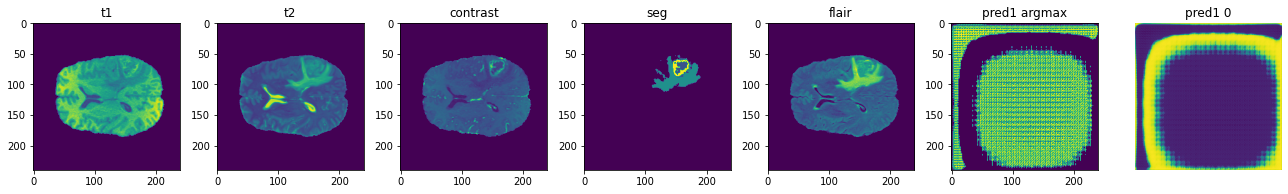

In [17]:
i=2

minipred_dataset = get_dataset([f'/content/MyDrive/MyDrive/IDS705_Final/Data/train_tf/{sf}.tfrecord' for sf in val_ids[i:(i+1)]])
minipred_dataset = minipred_dataset.batch(1)
pred1 = new_model.predict(minipred_dataset, batch_size=4)

subfolder_name = val_ids[i]
img1 = nib.load(f'Data/Train/{subfolder_name}/{subfolder_name}_t1.nii.gz') #file_format - nifti
img2 = nib.load(f'Data/Train/{subfolder_name}/{subfolder_name}_t2.nii.gz') #file_format - nifti2
imgce = nib.load(f'Data/Train/{subfolder_name}/{subfolder_name}_t1ce.nii.gz') #file_format - ce
imgseg = nib.load(f'Data/Train/{subfolder_name}/{subfolder_name}_seg.nii.gz') #file_format - seg
imgflair = nib.load(f'Data/Train/{subfolder_name}/{subfolder_name}_flair.nii.gz') #file_format - flair
slice_no=75

fig,axs = plt.subplots(1,7,figsize=(18,5))
axs[0].imshow(img1.dataobj[:,:,slice_no])
axs[1].imshow(img2.dataobj[:,:,slice_no])
axs[2].imshow(imgce.dataobj[:,:,slice_no])
axs[3].imshow(imgseg.dataobj[:,:,slice_no])
axs[4].imshow(imgflair.dataobj[:,:,slice_no])
axs[5].imshow(pred1[0,:,:,slice_no,:].argmax(2))
axs[6].imshow(pred1[0,:,:,slice_no,0])

axs[0].set_title("t1")
axs[1].set_title("t2")
axs[2].set_title("contrast")
axs[3].set_title("seg")
axs[4].set_title("flair")
axs[5].set_title("pred1 argmax")
axs[6].set_title("pred1 0")
fig.tight_layout()
plt.axis('off')